<a href="https://colab.research.google.com/github/dardan-gashi01/IN3060-CW/blob/main/test_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** John Doe (200056789) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset.zip', 'Code', 'Models', 'Personal_Dataset', 'Untitled0.ipynb', 'test_functions.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import torch
from torchvision import datasets, models, transforms
import shutil
from skimage import img_as_ubyte, io, color
import cv2

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` to avoid having to reload them each time.

In [ ]:
#hog-svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog-svm.joblib'))
cnn = torch.load((os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN.pth')), map_location=torch.device('cpu'))
hogsvm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'HOGSVM.joblib'))
hogmlp = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'HOGMLP.joblib'))

# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

In [ ]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset.zip

!rm CW_Dataset.zip

In [ ]:
import os, shutil

def make_dir_if_not_exists(path):
  if not os.path.isdir(path):
    os.mkdir(path)


def dataFolder2(trainImgPath, testImgPath, trainLabelPath, testLabelPath):
  #creating empty folders
  make_dir_if_not_exists('./DataFolder')
  make_dir_if_not_exists('./DataFolder/train')
  make_dir_if_not_exists('./DataFolder/test')
  for i in range(1,8):
    make_dir_if_not_exists(f'./DataFolder/train/{str(i)}')
    make_dir_if_not_exists(f'./DataFolder/test/{str(i)}')

  trainPath = './DataFolder/train'
  testPath = './DataFolder/test'

  file_names = [file for file in os.listdir(trainImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (trainLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{trainImgPath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders


  file_names = [file for file in os.listdir(testImgPath) if file.endswith('.jpg')]
  parsed_data = {}
  with open (testLabelPath, "r") as myfile:
    data = myfile.readlines()
    for line_data in data:
      file_name, number = line_data.strip().split(" ")
      parsed_data[file_name] = number

  for file in file_names:
    shutil.copy(f"{testImgPath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")
    #print("image file: " + file + ' class: ' + parsed_data[file.replace("_aligned", "")])
  #load images into the correct folders

In [ ]:
dataFolder2('train', 'test', 'labels/list_label_train.txt', 'labels/list_label_test.txt')

In [ ]:
def import_selected_data(path, label_list):
    """Load images and labels from selected directories"""
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

**fixing up the data so that we can run tests on the pytorch model**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join('DataFolder', x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

class_names = image_datasets['test'].classes

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]} \n Actual: {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])
                #imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**FIXING DATA FOR THE HOGSVM MODEL**

In [ ]:
from skimage.feature import hog

def hogimages(images, labels):
  hog_list_test = []
  hog_features_test=[]
  labels_list_test = []

  for i in range(len(images)):
    img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

    hog_list_test.append(hog_image)
    labels_list_test.append(labels[i])
    hog_features_test.append(fd)


  hog_array_test = np.vstack(hog_list_test)
  hog_array_test = hog_array_test.reshape(len(labels_list_test), 100*100)
  return hog_array_test

In [ ]:
#plotting images for hog models
def plotImages(images, labels, pred):
  fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharex=True, sharey=True)

  for i in range(4):
    ax[i].imshow(images[i], cmap=plt.cm.gray)
    ax[i].set_title(f'actual: {labels[i]}, prediction: {pred[i]}')

  

**FIXING DATA FOR THEH HOGMLP MODEL**

In [ ]:
from skimage.feature import hog

def hogimages2(images, labels):
  hog_list_test = []
  hog_features_test=[]
  labels_list_test = []

  for i in range(len(images)):
    
    img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    
    fd, hog_image = hog(images[i], orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualize=True)

    hog_list_test.append(hog_image)
    labels_list_test.append(labels[i])
    hog_features_test.append(fd)


  hog_array_test = np.vstack(hog_list_test)
  hog_array_test = hog_array_test.reshape(len(labels_list_test), 100*100)
  #hog_array_test = hog_array_test.reshape(len(labels_list_test), hog_array_test[1]*hog_array_test[2])
  return hog_array_test

**EmotionRecognition Function**

In [ ]:
def EmotionRecognition(path_to_testset, model_type):
  X, y = import_selected_data(path_to_testset, label_list=['1', '2', '3','4','5','6','7'])
  #model_type values are SVM, MLP and CNN
  if(model_type == "hogsvm"):
    print("HOGSVM")
    testing = hogimages(X, y)
    y_pred = hogsvm.predict(testing)
    plotImages(X,y,y_pred)
  elif(model_type == "hogmlp"):
    print("HOGMLP")
    testing = hogimages2(X, y)
    y_pred = hogmlp.predict(testing)
    plotImages(X,y,y_pred)
  elif(model_type == "cnn"):
    print("CNN")
    cnn.eval()
    visualize_model(cnn)
  else:
    print("type a valid model")

Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

CNN


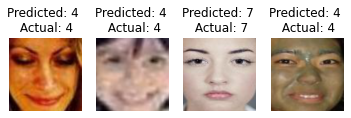

In [ ]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hog-svm
#   - hog-mlp
#   - cnn

path_to_testset = ('DataFolder/test')
EmotionRecognition(path_to_testset, 'cnn')

# Test EmotionRecognition in the wild

This section should allow a quick test of the `EmotionRecognition` on your `Personal_Dataset`.

In [ ]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - hog-svm
#   - hog-mlp
#   - cnn


path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
EmotionRecognition(path_to_testset, 'hogmlp')

HOGMLP


TypeError: ignored